In [55]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans

import warnings
#warnings.filterwarnings('ignore')
warnings.resetwarnings()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Static data
counties, counties_date = load_counties()

In [3]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, ma_width=7, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

In [4]:
deaths_df.columns

Index(['FIPS', 'day_01', 'day_02', 'day_03', 'day_04', 'day_05', 'day_06',
       'day_07', 'day_08', 'day_09', 'day_10', 'day_11', 'day_12', 'day_13',
       'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20',
       'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27',
       'day_28', 'onset', 'Beds', 'HospCt', 'OD_baseline', 'OD_at_onset',
       'OD_2wk_before_onset', 'OD_2wk_after_onset',
       'Rural-urban_Continuum Code_2013',
       'Density per square mile of land area - Population',
       'Percent of adults with less than a high school diploma 2014-18',
       'PCTPOV017_2018', 'Unemployment_rate_2018', 'Total_age65plus',
       'POP_ESTIMATE_2018', 'onset_relative'],
      dtype='object')

In [268]:
ddf = deaths_df.copy()
ddf = ddf.merge(counties[counties.columns.difference(ddf.columns).to_list() + ['FIPS']], on='FIPS')

## Normalized Mobility
ddf['OD_at_onset_normalized'] = ddf['OD_at_onset'] / ddf['OD_baseline']
ddf['OD_2wk_before_onset_normalized'] = ddf['OD_2wk_before_onset'] / ddf['OD_baseline']
ddf['OD_2wk_after_onset_normalized'] = ddf['OD_2wk_after_onset'] / ddf['OD_baseline']

## Black, african, hispanic, native american population
ddf['BAHN'] = ddf[['H_FEMALE', 'H_MALE', 'BA_FEMALE', 'BA_MALE', 'IA_MALE', 'IA_FEMALE']].sum(axis=1)

pop_vars = [
    'day_28',
    'Beds',
    'HospCt',
    'Total_age65plus',
    'POVALL_2018',
    'BAHN',
]
ddf[[l + '_normalized' for l in pop_vars]] = ddf[pop_vars].div(ddf['POP_ESTIMATE_2018'], axis=0)

## Normalize others
log_vars = [
    'day_28_normalized',
    'day_28',
    'OD_at_onset',
    'OD_baseline',
    'POP_ESTIMATE_2018',
    'Density per square mile of land area - Population',
    'Density per square mile of land area - Housing units',
]
## Compensate for 0 being a possible value
ddf[[l + ' (log)' for l in log_vars]] = ddf[log_vars].transform('log')


##
UPPER_CUTOFF = np.inf
LOWER_CUTOFF = 4

ddf = ddf[ddf[days[-1]] >= LOWER_CUTOFF]
ddf = ddf[ddf[days[-1]] <= UPPER_CUTOFF]

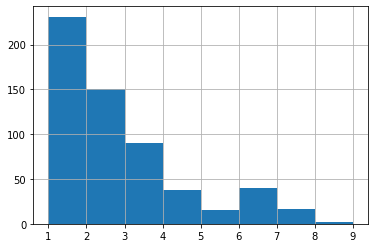

In [269]:
ddf['Rural-urban_Continuum Code_2013'].hist(bins=np.arange(1,10))

## RUCC Stratify

In [270]:
RUCC = 3
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

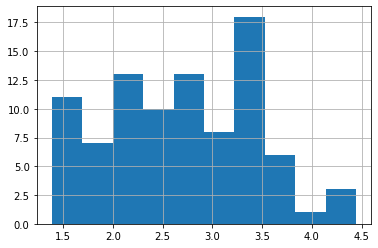

In [271]:
strat_df['day_28'].transform('log').hist()

## Shape class

In [272]:
def plot(labels, label, n = 5, show=True):
    idxs = np.where(labels == label)[0][:n]
    n = min(len(idxs), n)
    fig,axes = plt.subplots(n,1,figsize=(1.5*5,1.5*n), sharex=True)
    if n == 1:
        axes = [axes]
    for i,idx in enumerate(idxs):
        y = X[idx]
        FIPS = ddf.iloc[idx]['FIPS']
        l = ', '.join(counties[counties['FIPS'] == FIPS][['Area_Name', 'State']].values[0])
        axes[i].plot(np.arange(len(y)), y, label=l)
        axes[i].legend(loc='upper left')
    axes[0].set_title(f'Cluster {label+1}, Size={len(np.where(labels == label)[0])}')
    plt.tight_layout()
    if show:
        plt.show()
    else:
        plt.savefig(f'../figures/dtw_cluster-{label+1}.pdf')
    plt.close()

In [273]:
X = strat_df[days].values
X -= X.min(axis=1)[:,None]
X /= X.max(axis=1)[:,None]
clustering = AgglomerativeClustering(n_clusters=4, linkage='average', affinity='euclidean').fit(X)

In [274]:
X = strat_df[days].values
X -= X.min(axis=1)[:,None]
X /= X.max(axis=1)[:,None]
clustering = KMeans(n_clusters=4, random_state=0).fit(X)

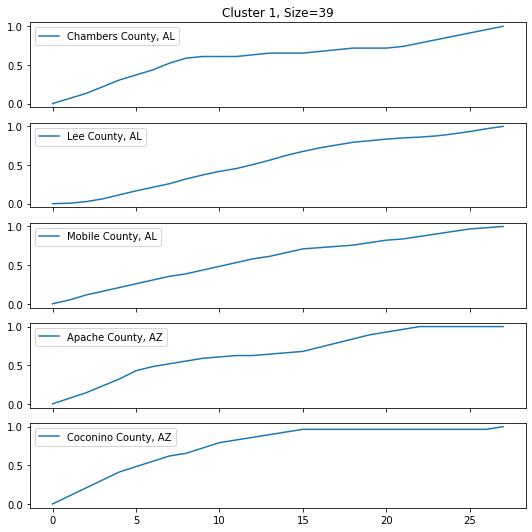

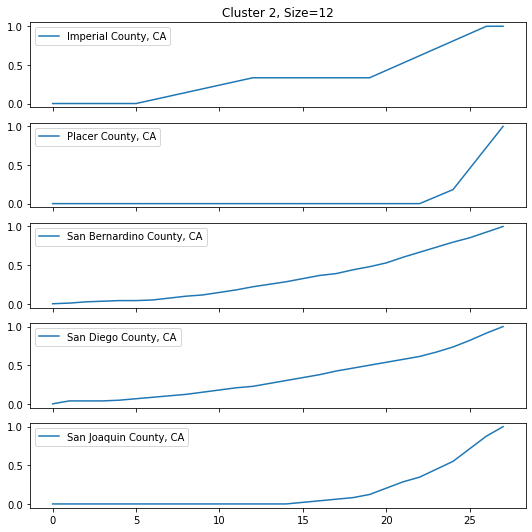

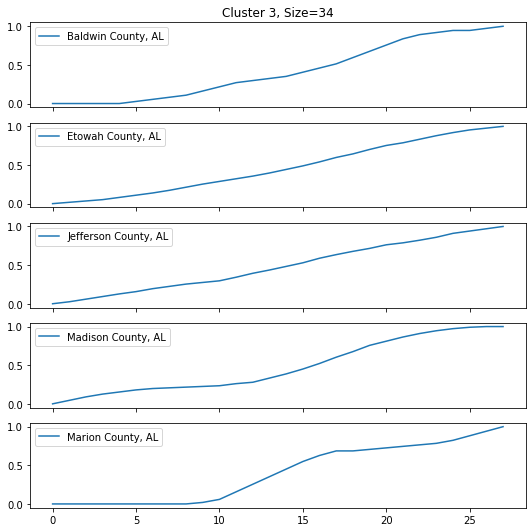

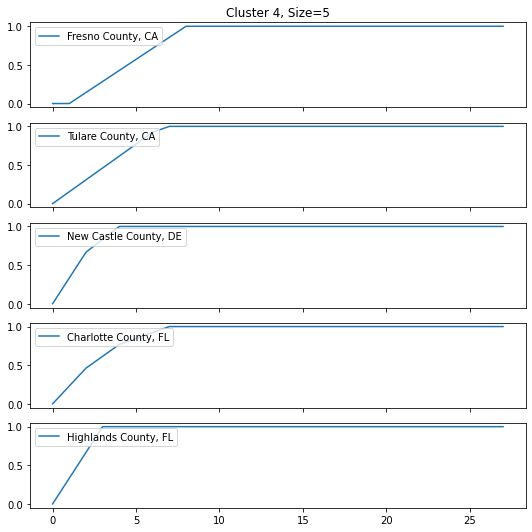

In [275]:
for label in np.unique(clustering.labels_):
    plot(clustering.labels_, label=label, n=5, show=True)

In [276]:
strat_df['shape_class'] = clustering.labels_

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


(array([ 6.,  6., 11., 14., 16., 17., 11.,  3.,  5.,  1.]),
 array([-10.71463997, -10.34070343,  -9.96676689,  -9.59283035,
         -9.21889382,  -8.84495728,  -8.47102074,  -8.0970842 ,
         -7.72314767,  -7.34921113,  -6.97527459]),
 <a list of 10 Patch objects>)

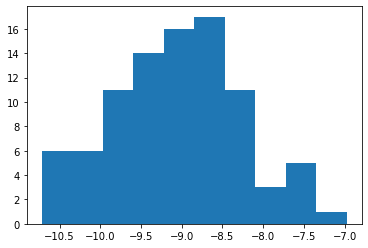

In [277]:
plt.hist(strat_df['day_28_normalized'].transform('log'))

## Stratfiy by pop/mobility

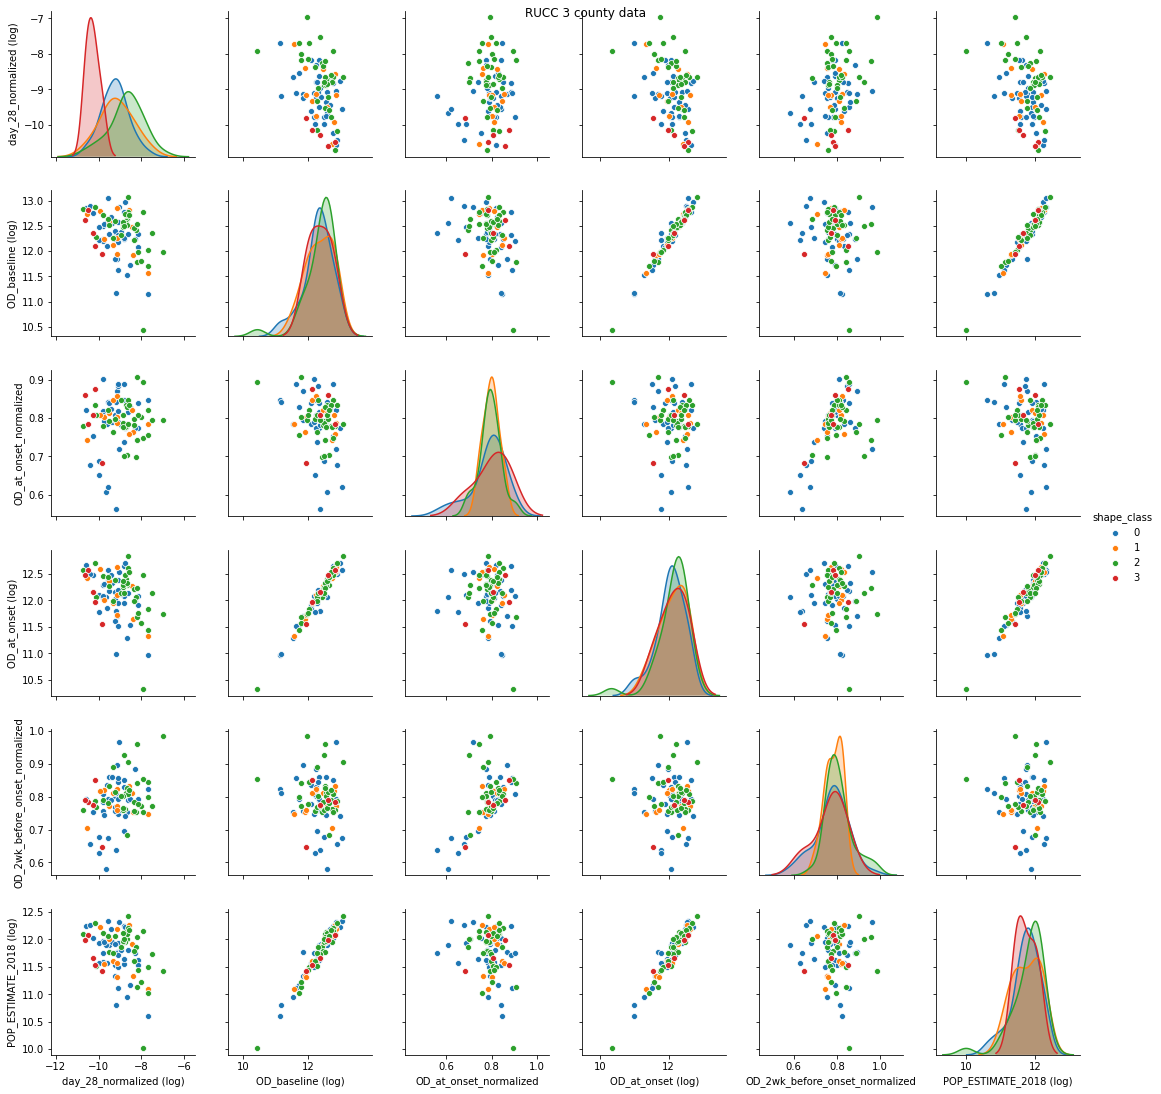

In [278]:
vars = [
    'day_28_normalized (log)',
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
]
hue = 'shape_class'
g = sns.pairplot(strat_df, vars=vars, hue=hue)
g.fig.suptitle(f'RUCC {3} county data', y=1, )
plt.show()

In [279]:
X = strat_df[['POP_ESTIMATE_2018 (log)', 'OD_at_onset_normalized']].values
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
clustering = KMeans(n_clusters=4, random_state=0).fit(XX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


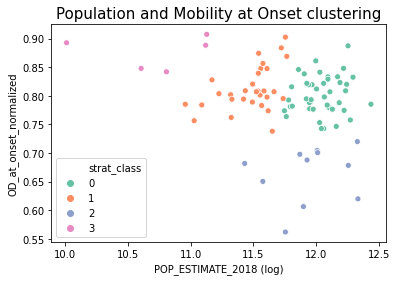

In [280]:
g = sns.scatterplot(
    x='POP_ESTIMATE_2018 (log)',
    y='OD_at_onset_normalized',
    data=strat_df,
    hue='strat_class',
 palette="Set2")
plt.title(f'Population and Mobility at Onset clustering', y=1, fontsize=15)
plt.show()

## Regress

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.linear_model import TweedieRegressor, LinearRegression, Lasso, ElasticNet
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

np.random.seed(0)

In [324]:
strat_class = 0
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_2wk_before_onset_normalized',# s,
    'Density per square mile of land area - Population (log)',# s,
    'Density per square mile of land area - Housing units (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
    #'shape_class',
]
target_var = 'day_28_normalized'

X = strat_df[strat_df['strat_class'] == strat_class][predictor_vars].copy()
y = strat_df[strat_df['strat_class'] == strat_class][target_var].copy()

In [339]:
categorical_features = []#['shape_class']
numeric_features = list(set(predictor_vars) - set(categorical_features))
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, numeric_features),
        #('cat', categorical_transformer, categorical_features)
])

## Gamma Regressor
model = TweedieRegressor(alpha=0.1, link='log', power=2)#Lasso()#LinearRegression()#ElasticNet()

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('learner', model)
])

In [340]:
clf = clf.fit(X, y)
y_hat = clf.predict(X)

In [341]:
def get_feature_out(estimator, feature_in):
    if hasattr(estimator,'get_feature_names'):
        return estimator.get_feature_names(feature_in)
    else:
        return feature_in

def get_ct_feature_names(ct):
    # handles all estimators, pipelines inside ColumnTransfomer
    # doesn't work when remainder =='passthrough'
    # which requires the input column names.
    output_features = []

    for name, estimator, features in ct.transformers_:
        if isinstance(estimator, Pipeline):
            current_features = features
            for step in estimator:
                current_features = get_feature_out(step, current_features)
            features_out = current_features
        else:
            features_out = get_feature_out(estimator, features)
        output_features.extend(features_out)

    return output_features

In [342]:
pd.DataFrame(clf['learner'].coef_[None, :], 
             columns=get_ct_feature_names(clf.named_steps['preprocessor']))

,Beds_normalized,HospCt_normalized,Total_age65plus_normalized,OD_2wk_before_onset_normalized,Density per square mile of land area - Housing units (log),POVALL_2018_normalized,onset_relative,Density per square mile of land area - Population (log),OD_baseline (log),OD_at_onset_normalized,BAHN_normalized,POP_ESTIMATE_2018 (log)
0,-0.019751,-0.000675,0.053956,0.217128,0.106345,0.165222,-0.228087,0.10694,-0.129071,-0.111097,-0.045454,0.018262


In [338]:
print(f'R2 Score {clf.score(X,y)}')

R2 Score 0.02686482261267531


## Grid search

In [76]:
parameters = {
    'learner__alpha':[0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0],
    #'learner__l1_ratio':[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
}
gscv = GridSearchCV(clf, parameters, cv=10)
gscv = gscv.fit(X, y)

In [80]:
pd.concat([
    pd.DataFrame(gscv.cv_results_["params"]),
    pd.DataFrame(gscv.cv_results_["mean_test_score"], columns=["Accuracy"])
],axis=1)

,learner__alpha,Accuracy
0,0.001,-2.542268
1,0.010,-2.023170
2,0.100,-1.272163
3,0.500,-0.885446
4,1.000,-0.805950
5,2.000,-0.762897
6,5.000,-0.737152


## GAMs

In [296]:
from pygam import PoissonGAM, GammaGAM, f, s, te

In [297]:
strat_class = 0
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_2wk_before_onset_normalized',# s,
    'Density per square mile of land area - Population (log)',# s,
    'Density per square mile of land area - Housing units (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
target_var = 'day_28_normalized'

X = strat_df[strat_df['strat_class'] == strat_class][predictor_vars].copy().values
y = strat_df[strat_df['strat_class'] == strat_class][target_var].copy().values

In [312]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
n_splines = X.shape[0] + 3 + 1

ggam = GammaGAM(s(0, n_splines=n_splines)+ # 'onset_relative'
                s(1, n_splines=n_splines)+#, constraints='monotonic_inc')+ # 'OD_baseline (log)'
                s(2, n_splines=n_splines)+#, constraints='monotonic_inc')+ # 'OD_at_onset_normalized'
                s(3, n_splines=n_splines)+#, constraints='monotonic_inc')+ # 'OD_2wk_before_onset_normalized'
                s(4, n_splines=n_splines)+#, constraints='monotonic_inc')+ # 'Density per square mile of land area - Population (log)'
                s(5, n_splines=n_splines)+#, constraints='monotonic_inc')+ # 'Density per square mile of land area - Housing units (log)'
                s(6, n_splines=n_splines)+ # 'POP_ESTIMATE_2018 (log)'
                s(7, n_splines=n_splines)+ # 'Beds_normalized'
                s(8, n_splines=n_splines)+ # 'HospCt_normalized'
                s(9, n_splines=n_splines)+ # 'Total_age65plus_normalized'
                s(10, n_splines=n_splines)+ # 'POVALL_2018_normalized'
                s(11, n_splines=n_splines)
               )

In [313]:
lams = np.random.rand(100, 12) # random points on [0, 1], with shape (100, 3)
lams = lams * 8 - 3 # shift values to -3, 3
lams = np.exp(lams) # transforms values to 1e-3, 1e3

ggam.gridsearch(X, y, lam=lams)

100% (100 of 100) |######################| Elapsed Time: 0:01:11 Time:  0:01:11


GammaGAM(callbacks=[Deviance(), Diffs()], fit_intercept=True, 
   max_iter=100, scale=None, 
   terms=s(0) + s(1) + s(2) + s(3) + s(4) + s(5) + s(6) + s(7) + s(8) + s(9) + s(10) + s(11) + intercept,
   tol=0.0001, verbose=False)

In [314]:
ggam.summary()

GammaGAM                                                                                                  
=============================================== ==========================================================
Distribution:                         GammaDist Effective DoF:                                      1.0626
Link Function:                          LogLink Log Likelihood:                                   348.4512
Number of Samples:                           44 AIC:                                             -692.7771
                                                AICc:                                            -692.4685
                                                GCV:                                                0.7778
                                                Scale:                                              0.6642
                                                Pseudo R-Squared:                                  -0.6736
Feature Function                  Lam

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """Entry point for launching an IPython kernel.


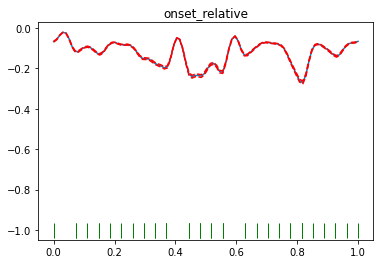

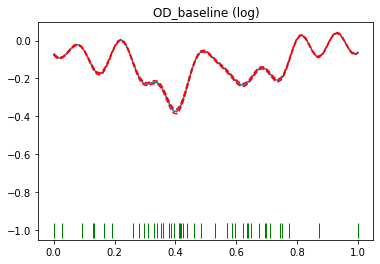

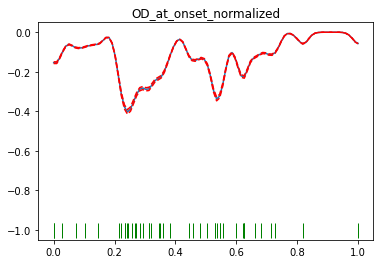

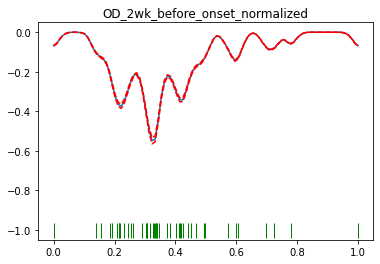

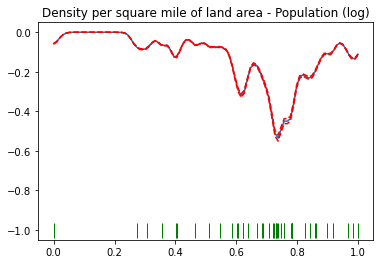

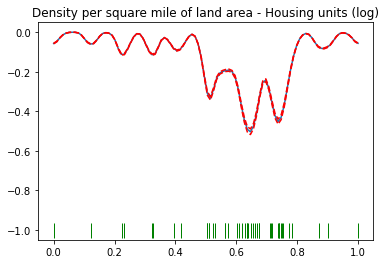

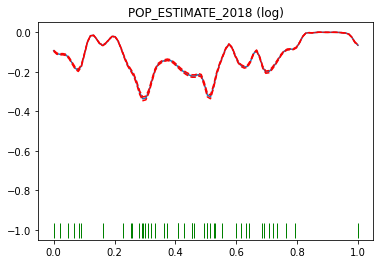

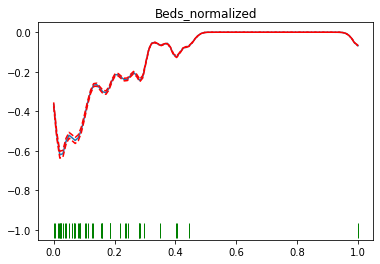

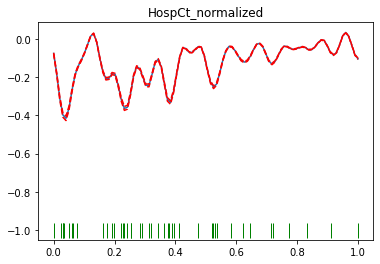

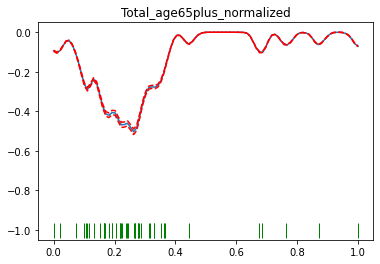

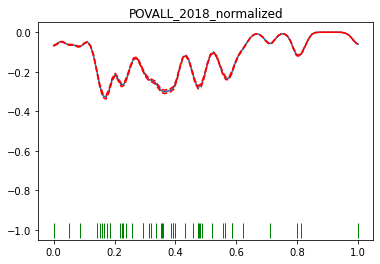

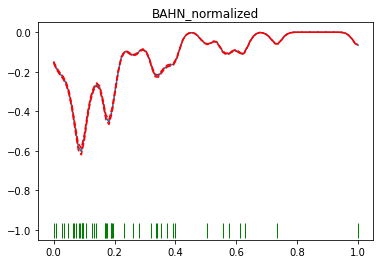

In [316]:
for i, term in enumerate(ggam.terms):
    if term.isintercept:
        continue

    XX = ggam.generate_X_grid(term=i)
    pdep, confi = ggam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.plot(X[:,i], np.ones(X[:,i].shape)*-1, 'b|', ms=15, c='g')
    plt.title(predictor_vars[i])
    plt.show()

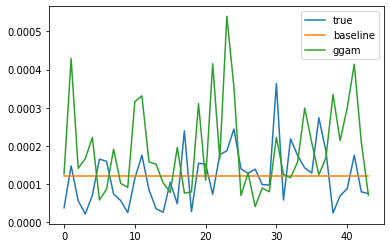

In [302]:
plt.plot(np.arange(len(y)), y, label='true')
plt.plot(np.arange(len(y)), np.ones(len(y))*np.mean(y), label='baseline')
plt.plot(np.arange(len(y)), ggam.predict(X), label='ggam')
plt.legend()